In [147]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from prettytable import PrettyTable
%matplotlib inline

In [129]:
_PickleFilesFolder="pickle_files"
_PickleFile_Merged_Listing_NY="Merged_Listing_NY"
_PickleFile_Vectorized_Data="NY_Vectors"
_FolderPath="data"
_Pretty_table_logs = PrettyTable()
_Pretty_table_logs.field_names = ["Model Name", "MAE", "MSE","RMSE","R2"]

In [7]:
def getDataFrameFromNParray(fileName):
    arr =np.load( "./" + _FolderPath + "/" + _PickleFile_Merged_Listing_NY + "_" + fileName)['arr_0']
    return(pd.DataFrame(arr))

In [110]:
def getTrainingData(typeOfModel,sampleSize=-1):
    if (typeOfModel=="corr"):
        trainFile= "c_X_train_Final_1.npz"
        testFile="c_X_test_Final_1.npz"
        
    ytrainFile="c_y_train.npz"
    ytestFile="c_y_test.npz"
    
    X_train=getDataFrameFromNParray(trainFile)
    X_test=getDataFrameFromNParray(testFile)
    y_train=getDataFrameFromNParray(ytrainFile)
    y_test=getDataFrameFromNParray(ytestFile)
    if sampleSize >0 :
        X_train=X_train.head(sampleSize)
        X_test=X_test.head(sampleSize)
        y_train=y_train.head(sampleSize)
        y_test=y_test.head(sampleSize)
    return X_train,X_test,y_train,y_test

In [64]:
def trainModel(objModelType,X,y,gridSearhParams):
    # define evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search
    gsv = GridSearchCV(objModelType, gridSearhParams, scoring='r2', n_jobs=-1, cv=cv,verbose=3,return_train_score=True)
    # execute search
    result = gsv.fit(X, y)
   
    return result   

In [70]:
ridge_alpha=[10,15,25,30,50,100,150,200,500,600,700,750,785,790,800,900,1000,1001]
def trainRidgeModel(X,y):
    model = Ridge()
    space = dict()
    #space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
    space['alpha'] = ridge_alpha
    #space['fit_intercept'] = [True, False]
    #space['normalize'] = [True, False]
    return trainModel(model,X,y,space)

In [71]:
lasso_alpha=[0.0005,0.0006,0.06,0.5,0.0001,0.01,1,2,3,4,4.4,4]
def trainLassoModel(X,y):
    model = Lasso ()
    space = dict()
    #space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
    space['alpha'] = lasso_alpha
    #space['fit_intercept'] = [True, False]
    #space['normalize'] = [True, False]
    return trainModel(model,X,y,space)

In [139]:
lasso_e=[0.0005,0.0006,0.06,0.5,0.0001,0.01,1]
def trainElasticNetModel(X,y):
    model = ElasticNet ()
    space = dict()
    #space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
    space['alpha'] = lasso_e
    #space['fit_intercept'] = [True, False]
    #space['normalize'] = [True, False]
    return trainModel(model,X,y,space)

In [150]:
svr_c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
def trainSVR(X,y):
    parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'epsilon':[0.1,0.2,0.5,0.3]}
    model = SVR()
    return trainModel(model,X,y,parameters)

In [93]:
def plotValidationGraph(cs, clf, plt_title):
    #import math
    log_c =cs

   # for a in cs:
      #  b = math.log(a)
     #   log_c.append(b)

    plt.figure(figsize=(20,10))

    train_rmse = clf.cv_results_['mean_train_score']
    #train_auc_std = clf.cv_results_['std_train_score']
    cv_rmse = clf.cv_results_['mean_test_score'] 
    #cv_auc_std= clf.cv_results_['std_test_score']

    plt.plot(log_c, train_rmse, label='Score Train')
    plt.plot(log_c, cv_rmse, label='Score CV')

    plt.scatter(log_c, train_rmse, label='Alphas Train')
    plt.scatter(log_c, cv_rmse, label='Alphas CV')

    plt.xlabel('Hyperparameter - Alpha')
    plt.ylabel('RMSE')
    plt.title("Score on various Alphas using %s on  "%plt_title)
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.legend()

In [135]:
def getPredictions(model,X_tr,y_tr,X_te,y_te,modelName=""):
    model.fit(X_tr,y_tr)
    predictions=model.predict(X_te)
    mae = metrics.mean_absolute_error(y_te, predictions)
    mse = metrics.mean_squared_error(y_te, predictions)
    rmse = np.sqrt(metrics.mean_squared_error(y_te, predictions))
    r2 = metrics.r2_score(y_te, predictions)

    #print('MAE (Mean Absolute Error): %s' %mae)
    #print('MSE (Mean Squared Error): %s' %mse)
    #print('RMSE (Root mean squared error): %s' %rmse)
    #print('R2 score: %s' %r2)
    if len(modelName) >0:
        _Pretty_table_logs.add_row([modelName, mae, mse,rmse,r2 ])
        print (_Pretty_table_logs)
    return model,predictions

In [113]:
def getPredictionsGraph(y_te,predictions):
    # Evaluated predictions

    plt.figure(figsize=(15,7))
    plt.xlim(-10,350)
    sns.regplot(y=y_te, x=predictions, color='blue')
    plt.title('Evaluated predictions', fontsize=15)
    plt.xlabel('Predictions')
    plt.ylabel('Test')

# 1.   Regression Models With Removal  Corelated Features 

In [111]:
X_train,X_test,y_train,y_test=getTrainingData("corr",1000)

##  1. 1 Ridge Regression

In [90]:
clf=trainRidgeModel(X_train,y_train)

Fitting 30 folds for each of 18 candidates, totalling 540 fits


ValueError: x and y must have same first dimension, but have shapes (18,) and (12,)

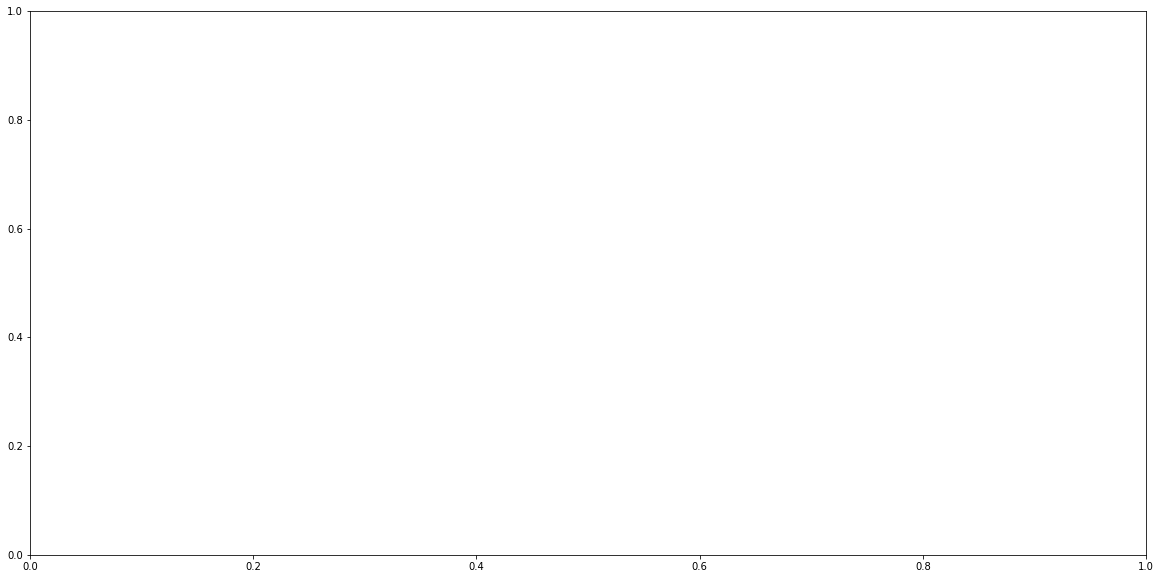

In [117]:
plotValidationGraph(ridge_alpha,clf,'Ridge Model')

In [98]:

print('Best Alpha:', clf.best_estimator_.get_params()['alpha'])
print ('Best Score:',clf.best_score_)
bestAlpha= clf.best_estimator_.get_params()['alpha']
bestScore=clf.best_score_


Best Alpha: 150
Best Score: 0.5143632973304456


In [114]:
model,predictions= getPredictions(Ridge(alpha=bestAlpha),X_train,y_train,X_test,y_test)


MAE (Mean Absolute Error): 91.17688799999999
MSE (Mean Squared Error): 60444.881451999994
RMSE (Root mean squared error): 245.85540761187255
R2 score: -0.00016272835871466995


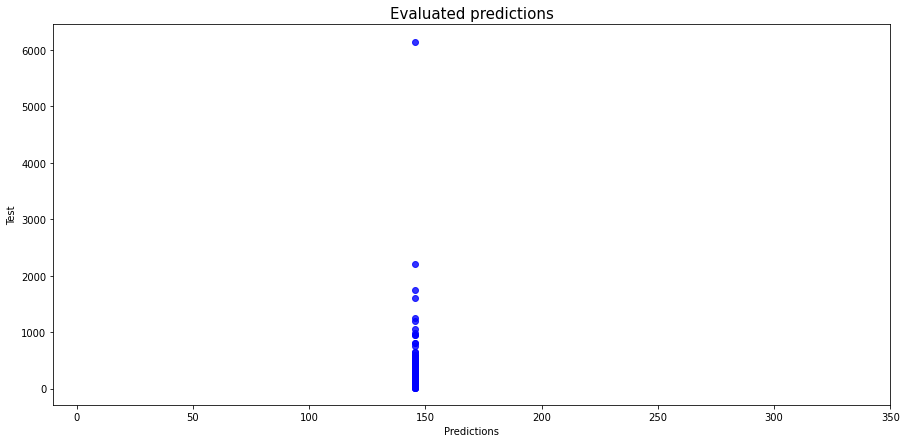

In [115]:
# Evaluated predictions
getPredictionsGraph(y_test,predictions)


## 1.2 Lasso Regression

In [116]:
clf=trainLassoModel(X_train,y_train)

Fitting 30 folds for each of 12 candidates, totalling 360 fits


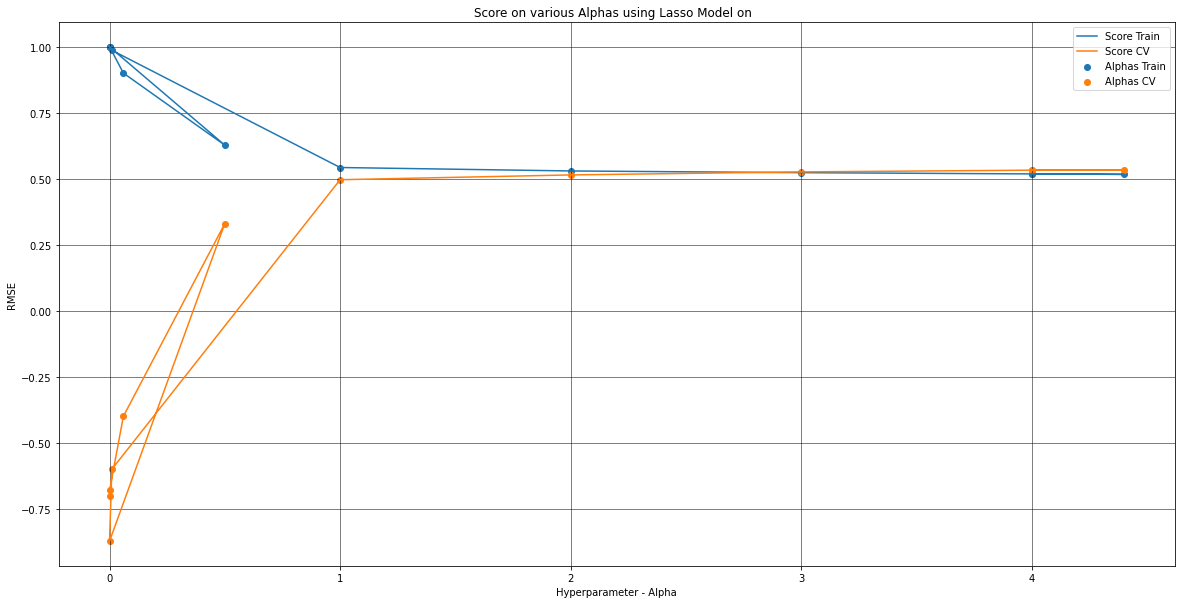

In [118]:
plotValidationGraph(lasso_alpha,clf,'Lasso Model')


In [119]:
print('Best Alpha:', clf.best_estimator_.get_params()['alpha'])
print ('Best Score:',clf.best_score_)
bestAlpha= clf.best_estimator_.get_params()['alpha']
bestScore=clf.best_score_

Best Alpha: 4.4
Best Score: 0.534743795458612


In [136]:
model,predictions= getPredictions(Lasso(alpha=bestAlpha),X_train,y_train,X_test,y_test,"Lasso")

+------------+-------------------+--------------------+--------------------+---------------------+
| Model Name |        MAE        |        MSE         |        RMSE        |          R2         |
+------------+-------------------+--------------------+--------------------+---------------------+
|   Lasso    | 62.37715266873881 | 48908.031968350275 | 221.15160403747984 | 0.19073394608333827 |
|   Lasso    | 62.37715266873881 | 48908.031968350275 | 221.15160403747984 | 0.19073394608333827 |
|   Lasso    | 62.37715266873881 | 48908.031968350275 | 221.15160403747984 | 0.19073394608333827 |
+------------+-------------------+--------------------+--------------------+---------------------+


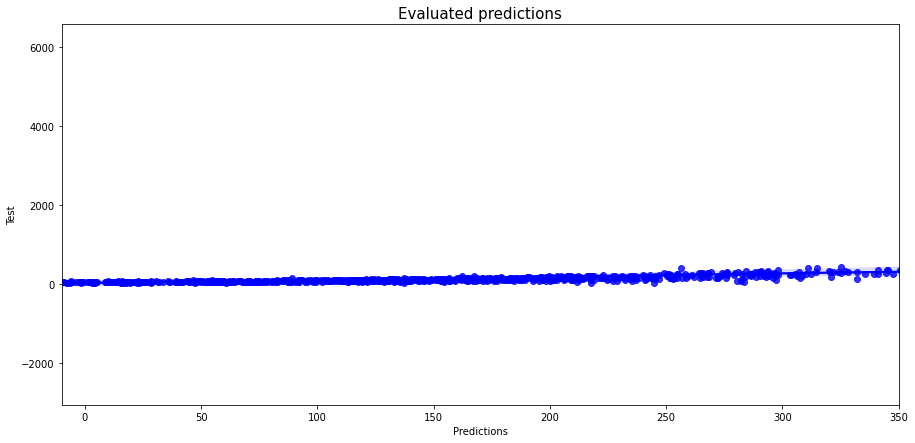

In [121]:
# Evaluated predictions
getPredictionsGraph(y_test,predictions)

# 1.3 Elastic Net Regression

In [140]:
clf=trainElasticNetModel(X_train,y_train)

Fitting 30 folds for each of 7 candidates, totalling 210 fits


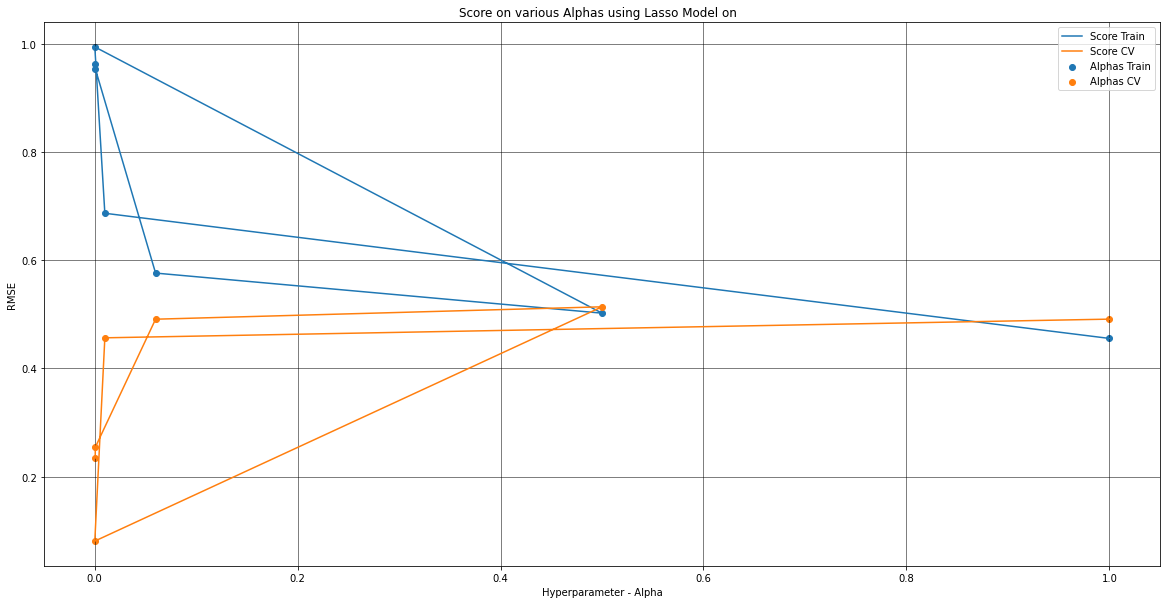

In [141]:
plotValidationGraph(lasso_e,clf,'Elastic Net Model')

In [142]:
print('Best Alpha:', clf.best_estimator_.get_params()['alpha'])
print ('Best Score:',clf.best_score_)
bestAlpha= clf.best_estimator_.get_params()['alpha']
bestScore=clf.best_score_

Best Alpha: 0.5
Best Score: 0.5137639548314716


In [143]:
model,predictions= getPredictions(ElasticNet(alpha=bestAlpha),X_train,y_train,X_test,y_test,"Elastic net")

+-------------+--------------------+--------------------+--------------------+---------------------+
|  Model Name |        MAE         |        MSE         |        RMSE        |          R2         |
+-------------+--------------------+--------------------+--------------------+---------------------+
|    Lasso    | 62.37715266873881  | 48908.031968350275 | 221.15160403747984 | 0.19073394608333827 |
|    Lasso    | 62.37715266873881  | 48908.031968350275 | 221.15160403747984 | 0.19073394608333827 |
|    Lasso    | 62.37715266873881  | 48908.031968350275 | 221.15160403747984 | 0.19073394608333827 |
| Elastic net | 58.444917946730214 | 47714.73143770345  | 218.43701938477244 | 0.21047912029517624 |
+-------------+--------------------+--------------------+--------------------+---------------------+


## 1.4 Support Vector Regressor

In [151]:
clf=trainSVR(X_train,y_train)

Fitting 30 folds for each of 420 candidates, totalling 12600 fits


KeyboardInterrupt: 

In [ ]:
plotValidationGraph(lasso_e,clf,'Elastic Net Model')

In [ ]:
print('Best Alpha:', clf.best_estimator_.get_params()['alpha'])
print ('Best Score:',clf.best_score_)
bestAlpha= clf.best_estimator_.get_params()['alpha']
bestScore=clf.best_score_

In [ ]:
model,predictions= getPredictions(ElasticNet(alpha=bestAlpha),X_train,y_train,X_test,y_test,"Elastic net")